# Whole brain data processing

In [2]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing_single_WS import *
import scipy.ndimage.filters as sfilter

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190426/fish03/7dpf_HuC-H2B_GCaMP7ff_GU-slow-fwd_fish03_exp02_20190426_221213/'
# save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190430/fish01/6dpf_HuC-GCaMP7ff-GFAP-RGECO_GU-slow-fwd_fish01_exp01_20190430_174349/'
save_root = '/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20190907/fish00/7dpf_HuC-GC7FF_GU-fwd_fish00_exp01_20190907_172639/'

In [4]:
import zarr
_ = zarr.open(save_root+'motion_corrected_data.zarr', mode='r')
_, dx, dy, _ = _.chunks
brain_map = np.load(save_root+'Y_ave.npy')

In [5]:
# dense
# _ = np.load(save_root+'cell_raw_dff.npz', allow_pickle=True)
# sparse
_ = np.load(save_root+'cell_raw_dff_sparse.npz', allow_pickle=True)
A = _['A']
F_ = _['F']
A_loc = _['A_loc']

In [6]:
A.shape

(505000, 100, 100)

In [7]:
# cell_id = 175000
cell_id = 110000
A_ = A[cell_id]
A_loc_ = A_loc[cell_id]
z, x, y = A_loc_
A_ext = np.zeros((brain_map.shape[1],brain_map.shape[2]))
A_ext[x:x+100, y:y+100]=A_

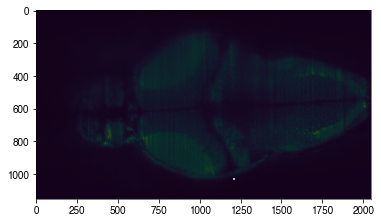

In [8]:
plt.imshow(brain_map[z].squeeze())
plt.imshow(A_ext>0, cmap='gray', alpha=0.7)

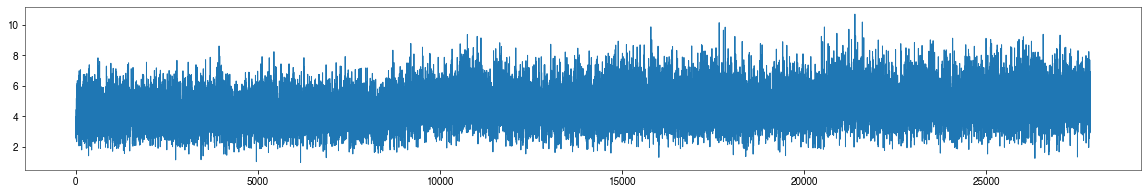

In [9]:
plt.figure(figsize=(20, 3))
plt.plot(F_[cell_id])
plt.show()

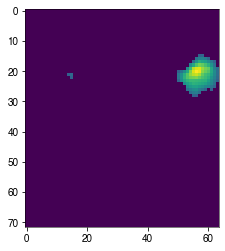

In [10]:
plt.imshow(A_[:dx, :dy])

# Check components by blocks

In [11]:
Y_d_max = brain_map.max(axis=0).squeeze()
max_ = np.percentile(Y_d_max, 45)
mask_ = Y_d_max>max_

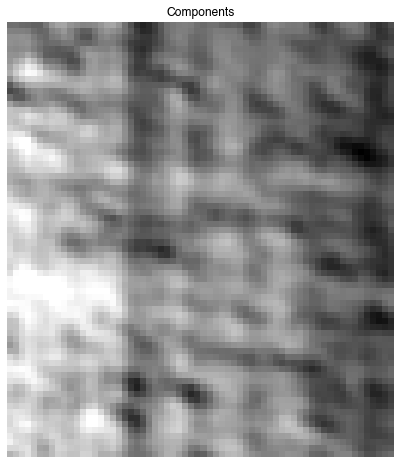

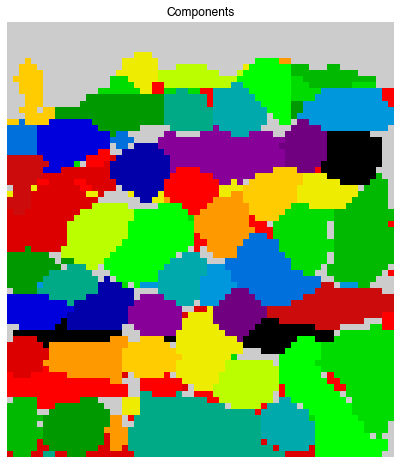

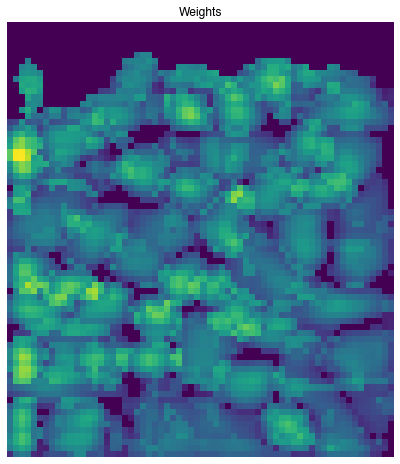

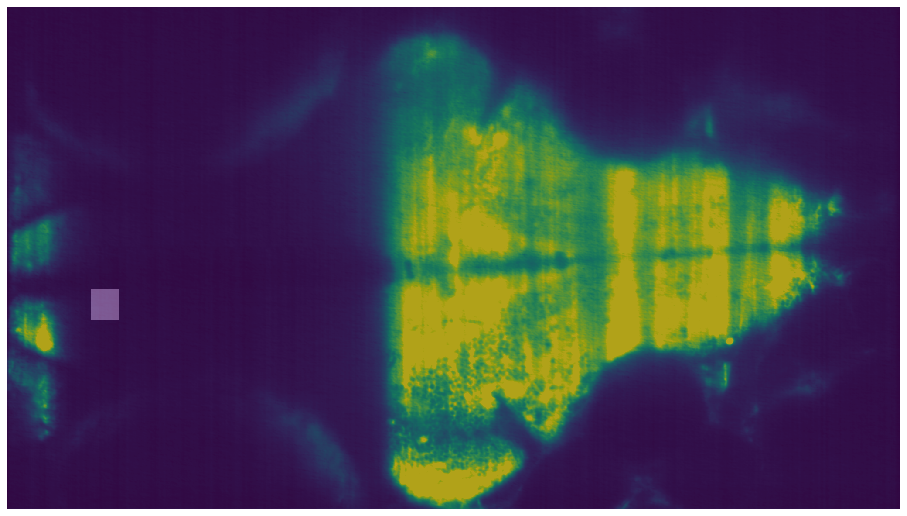

In [12]:
block_id = (10, 9, 3, 0)
check_demix_cells(save_root, block_id, mask=mask_)